In [1]:
%%capture
!pip install -qq ipywidgets
!pip install -qq autogluon scikit-learn==1.5.2

In [2]:
%%capture
!apt-get -qq install -y graphviz graphviz-dev && pip install -qq pydot
!pip install -qq pygraphviz

In [3]:
import torch
import os
import pydot

import numpy as np
import pandas as pd
from time import time
from tqdm.auto import tqdm
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import shap

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
# plt.style.use("ggplot")
sns.set_style("whitegrid")

## -- Define ansi color codes --
COLOR = '\033[93m'
RESET = '\033[0m'

In [4]:
OOF = pd.DataFrame()
PREDS = pd.DataFrame()

for (root, dirs, files) in os.walk("/kaggle/input/s5e9-beats-oof"):
    for file in tqdm(sorted(files), desc="Loading files"):
        if file.endswith(".parquet") and "oof" in file:
            OOF = pd.concat([OOF, pd.read_parquet(os.path.join(root, file))], axis=1)
        elif file.endswith(".parquet") and "pred" in file:
            PREDS = pd.concat([PREDS, pd.read_parquet(os.path.join(root, file))], axis=1)

print(f"{COLOR}Total OOF models  : {len(OOF.columns)}")
print(f"Total PREDS models: {len(PREDS.columns)}")

Loading files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading files: 0it [00:00, ?it/s]

Loading files:   0%|          | 0/106 [00:00<?, ?it/s]

Total OOF models  : 424
Total PREDS models: 424


In [5]:
def rename_duplicate_cols(df: pd.DataFrame) -> pd.DataFrame:
    original_cols = list(df.columns)
    new_cols = []
    # Track how many times we've seen each original name
    seen = {}

    for col in tqdm(original_cols, desc="Fixing columns"):
        if col not in seen:
            # First occurrence: keep name unchanged
            seen[col] = 1
            new_cols.append(col)
        else:
            # Duplicate: append suffix _k where k starts at 0
            suffix = seen[col] - 1 # 0 for first duplicate, 1 for second...
            new_name = f"{col}_{suffix}"
            new_cols.append(new_name)
            seen[col] += 1

    # Apply new column names
    df = df.copy()
    df.columns = new_cols
    print(f"{COLOR}{len(new_cols)} Columns fixed!!!{RESET}")

    return df

train = rename_duplicate_cols(OOF)
test = rename_duplicate_cols(PREDS)

Fixing columns:   0%|          | 0/424 [00:00<?, ?it/s]

424 Columns fixed!!!


Fixing columns:   0%|          | 0/424 [00:00<?, ?it/s]

424 Columns fixed!!!


In [6]:
PATH    = "/kaggle/input/playground-series-s5e9/"
TR      = pd.read_csv(PATH + "train.csv", index_col='id') #.drop('id', axis=1) 
TARGET  = "BeatsPerMinute"
train   = pd.concat([train, TR[TARGET]], axis=1)
submit  = pd.read_csv(PATH+"sample_submission.csv")
print(f"Shape of train data: {train.shape}")
train.head()

Shape of train data: (524164, 425)


,RandomForestMSEBAGL1_FE99rlfx_CPU,ExtraTreesMSEBAGL1_FE99rlfx_CPU,NeuralNetFastAIBAGL1_FE99rlfx_CPU,NeuralNetTorchBAGL1_FE99rlfx_CPU,WeightedEnsembleL2_FE99rlfx_CPU,RandomForestMSEBAGL2_FE99rlfx_CPU,WeightedEnsembleL3_FE99rlfx_CPU,LightGBMXTBAGL1_FE185rlf_CPU,LightGBMBAGL1_FE185rlf_CPU,RandomForestMSEBAGL1_FE185rlf_CPU,NeuralNetFastAIBAGL1_FE185rlf_CPU,LightGBMLargeBAGL1_FE185rlf_CPU,LightGBMr131BAGL1_FE185rlf_CPU,NeuralNetFastAIr191BAGL1_FE185rlf_CPU,LightGBMr96BAGL1_FE185rlf_CPU,WeightedEnsembleL2_FE185rlf_CPU,LightGBMXTBAGL2_FE185rlf_CPU,LightGBMBAGL2_FE185rlf_CPU,RandomForestMSEBAGL2_FE185rlf_CPU,LightGBMLargeBAGL2_FE185rlf_CPU,WeightedEnsembleL3_FE185rlf_CPU,CAT_460434,LGBM_461364,LightGBMXTBAGL1_FEnums184_CPU,LightGBMBAGL1_FEnums184_CPU,RandomForestMSEBAGL1_FEnums184_CPU,CatBoostBAGL1_FEnums184_CPU,ExtraTreesMSEBAGL1_FEnums184_CPU,NeuralNetFastAIBAGL1_FEnums184_CPU,XGBoostBAGL1_FEnums184_CPU,LightGBMLargeBAGL1_FEnums184_CPU,WeightedEnsembleL2_FEnums184_CPU,LightGBMXTBAGL2_FEnums184_CPU,LightGBMBAGL2_FEnums184_CPU,RandomForestMSEBAGL2_FEnums184_CPU,WeightedEnsembleL3_FEnums184_CPU,LightGBMXTBAGL1_FE185_GPU,LightGBMBAGL1_FE185_GPU,RandomForestMSEBAGL1_FE185_GPU,CatBoostBAGL1_FE185_GPU,ExtraTreesMSEBAGL1_FE185_GPU,NeuralNetFastAIBAGL1_FE185_GPU,XGBoostBAGL1_FE185_GPU,NeuralNetTorchBAGL1_FE185_GPU,LightGBMLargeBAGL1_FE185_GPU,CatBoostr177BAGL1_FE185_GPU,NeuralNetTorchr79BAGL1_FE185_GPU,LightGBMr131BAGL1_FE185_GPU,CatBoostr9BAGL1_FE185_GPU,WeightedEnsembleL2_FE185_GPU,LightGBMXTBAGL2_FE185_GPU,LightGBMBAGL2_FE185_GPU,RandomForestMSEBAGL2_FE185_GPU,CatBoostBAGL2_FE185_GPU,NeuralNetFastAIBAGL2_FE185_GPU,XGBoostBAGL2_FE185_GPU,WeightedEnsembleL3_FE185_GPU,LightGBMXTBAGL1_FE185__CPU,LightGBMBAGL1_FE185__CPU,RandomForestMSEBAGL1_FE185__CPU,CatBoostBAGL1_FE185__CPU,ExtraTreesMSEBAGL1_FE185__CPU,XGBoostBAGL1_FE185__CPU,LightGBMLargeBAGL1_FE185__CPU,WeightedEnsembleL2_FE185__CPU,LightGBMXTBAGL2_FE185__CPU,LightGBMBAGL2_FE185__CPU,RandomForestMSEBAGL2_FE185__CPU,WeightedEnsembleL3_FE185__CPU,RandomForestMSEBAGL1_FE185rfx_CPU,ExtraTreesMSEBAGL1_FE185rfx_CPU,NeuralNetFastAIBAGL1_FE185rfx_CPU,NeuralNetFastAIr191BAGL1_FE185rfx_CPU,WeightedEnsembleL2_FE185rfx_CPU,RandomForestMSEBAGL2_FE185rfx_CPU,ExtraTreesMSEBAGL2_FE185rfx_CPU,WeightedEnsembleL3_FE185rfx_CPU,RandomForestMSEBAGL1_FE185rfx_GPU,ExtraTreesMSEBAGL1_FE185rfx_GPU,NeuralNetFastAIBAGL1_FE185rfx_GPU,NeuralNetFastAIr191BAGL1_FE185rfx_GPU,ExtraTreesr42BAGL1_FE185rfx_GPU,WeightedEnsembleL2_FE185rfx_GPU,RandomForestMSEBAGL2_FE185rfx_GPU,WeightedEnsembleL3_FE185rfx_GPU,RandomForestMSEBAGL1_FE185rfx__CPU,ExtraTreesMSEBAGL1_FE185rfx__CPU,NeuralNetFastAIBAGL1_FE185rfx__CPU,NeuralNetFastAIr191BAGL1_FE185rfx__CPU,WeightedEnsembleL2_FE185rfx__CPU,RandomForestMSEBAGL2_FE185rfx__CPU,WeightedEnsembleL3_FE185rfx__CPU,LightGBMXTBAGL1_FE185rlfx_CPU,LightGBMBAGL1_FE185rlfx_CPU,RandomForestMSEBAGL1_FE185rlfx_CPU,ExtraTreesMSEBAGL1_FE185rlfx_CPU,NeuralNetFastAIBAGL1_FE185rlfx_CPU,LightGBMLargeBAGL1_FE185rlfx_CPU,WeightedEnsembleL2_FE185rlfx_CPU,LightGBMXTBAGL2_FE185rlfx_CPU,LightGBMBAGL2_FE185rlfx_CPU,RandomForestMSEBAGL2_FE185rlfx_CPU,ExtraTreesMSEBAGL2_FE185rlfx_CPU,WeightedEnsembleL3_FE185rlfx_CPU,LightGBMXTBAGL1_FE194_CPU,LightGBMBAGL1_FE194_CPU,RandomForestMSEBAGL1_FE194_CPU,CatBoostBAGL1_FE194_CPU,ExtraTreesMSEBAGL1_FE194_CPU,XGBoostBAGL1_FE194_CPU,WeightedEnsembleL2_FE194_CPU,LightGBMXTBAGL2_FE194_CPU,LightGBMBAGL2_FE194_CPU,RandomForestMSEBAGL2_FE194_CPU,WeightedEnsembleL3_FE194_CPU,LightGBMXTBAGL1_FE194xlc_CPU,LightGBMBAGL1_FE194xlc_CPU,CatBoostBAGL1_FE194xlc_CPU,XGBoostBAGL1_FE194xlc_CPU,LightGBMLargeBAGL1_FE194xlc_CPU,CatBoostr177BAGL1_FE194xlc_CPU,LightGBMr131BAGL1_FE194xlc_CPU,CatBoostr9BAGL1_FE194xlc_CPU,LightGBMr96BAGL1_FE194xlc_CPU,XGBoostr33BAGL1_FE194xlc_CPU,CatBoostr137BAGL1_FE194xlc_CPU,CatBoostr13BAGL1_FE194xlc_CPU,LightGBMr188BAGL1_FE194xlc_CPU,XGBoostr89BAGL1_FE194xlc_CPU,LightGBMr130BAGL1_FE194xlc_CPU,CatBoostr50BAGL1_FE194xlc_CPU,XGBoostr194BAGL1_FE194xlc_CPU,CatBoostr69BAGL1

In [7]:
# !rm -r /kaggle/working/AG_beats_models

In [8]:
from autogluon.tabular import TabularPredictor

## -- RUN 1: Use train data --
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "regression",
          eval_metric = "rmse",
                 path = "./AG_beats_models",
).fit(
                   train_data = train,
                      presets = 'best_quality',
                num_bag_folds = 10,
                   time_limit = 3600*11.5,
         # included_model_types = ['RF','XT','FASTAI'],
        # [ 'XGB', 'GBM', 'CAT', 'RF', 'XT', 'FASTAI', 'NN_TORCH']
                  ag_args_fit = {'num_cpus': os.cpu_count()},
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       27.11 GB / 31.35 GB (86.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=10, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the d

In [9]:
## -- Get Summary -- 
print(f"""
    {'█'*5}| Total models : {len(predictor.model_names())}
    {'█'*5}| Best model   : {predictor.model_best}
        """)

## -- Observe RUN 1 RESULTS --
leaderboard = predictor.leaderboard(silent=True)
display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))


    █████| Total models : 10
    █████| Best model   : WeightedEnsemble_L3
        


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-26.430898,root_mean_squared_error,114.227349,27539.311647,0.007181,0.738891,3,True,10
1,WeightedEnsemble_L2,-26.431664,root_mean_squared_error,6.552132,2543.814623,0.007641,0.379980,2,True,5
2,LightGBMXT_BAG_L2,-26.431704,root_mean_squared_error,36.199328,20938.498780,2.239655,704.092004,2,True,6
3,CatBoost_BAG_L2,-26.432755,root_mean_squared_error,34.580786,20926.098177,0.621113,691.691401,2,True,8
4,LightGBMXT_BAG_L1,-26.433199,root_mean_squared_error,3.044252,942.330836,3.044252,942.330836,1,True,1
5,LightGBM_BAG_L1,-26.433518,root_mean_squared_error,2.727468,832.835035,2.727468,832.835035,1,True,2
6,CatBoost_BAG_L1,-26.433994,root_mean_squared_error,0.772771,768.268773,0.772771,768.268773,1,True,4
7,LightGBM_BAG_L2,-26.434027,root_mean_squared_error,35.786788,20816.012747,1.827115,581.605971,2,True,7
8,ExtraTreesMSE_BAG_L2,-26.504275,root_mean_squared_error,111.980512,26834.480752,78.020839,6600.073977,2,True,9
9,RandomForestMSE_BAG_L1,-26.742397,root_mean_squared_error,27.415182,17690.972132,27.415182,17690.972132,1,True,3


In [10]:
## -- Create folder directory to save predictions --
NAME_EXT = "_LV2_CPU"
!mkdir /kaggle/working/AG_beats_predictions{NAME_EXT}

In [11]:
## -- Make predictions from best model --
pred_df = predictor.predict(test)
pred_df.head()

0    119.052055
1    118.793304
2    119.248329
3    120.393646
4    119.612610
Name: BeatsPerMinute, dtype: float32

In [12]:
## -- Generate Submission --
FILE_NAME = f"submit_AG{NAME_EXT}.csv"

submit = pd.read_csv(PATH+"sample_submission.csv")
submit["BeatsPerMinute"] = pred_df.values
submit.to_csv(FILE_NAME, index=False)
print(f"{'█'*5}| Submission file {FILE_NAME} saved!")
submit.head(10)

█████| Submission file submit_AG_LV2_CPU.csv saved!


,id,BeatsPerMinute
0,524164,119.052055
1,524165,118.793304
2,524166,119.248329
3,524167,120.393646
4,524168,119.612610
5,524169,118.376007
6,524170,118.379929
7,524171,118.288887
8,524172,119.444061
9,524173,118.989708


In [13]:
## -- Generate prediction probabilities for all models --
ag_multi_test_proba = predictor.predict_multi(test)

## -- Get TEST PREDICTIONS of all models --
final_test_data = {}

for k, v in tqdm(ag_multi_test_proba.items(), desc="Exporting TEST predictions"):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_test_data[k_renamed] = v

final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(f"/kaggle/working/AG_beats_predictions{NAME_EXT}/predL2_ag{NAME_EXT}.parquet", index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/10 [00:00<?, ?it/s]

,LightGBMXTBAGL1_LV2_CPU,LightGBMBAGL1_LV2_CPU,RandomForestMSEBAGL1_LV2_CPU,CatBoostBAGL1_LV2_CPU,WeightedEnsembleL2_LV2_CPU,LightGBMXTBAGL2_LV2_CPU,LightGBMBAGL2_LV2_CPU,CatBoostBAGL2_LV2_CPU,ExtraTreesMSEBAGL2_LV2_CPU,WeightedEnsembleL3_LV2_CPU
0,119.128029,119.071671,120.094078,119.021484,119.088654,118.976929,118.961998,119.010818,119.379982,119.052055
1,118.604576,118.782776,119.688866,118.479874,118.663139,118.860672,118.937706,118.804581,119.180656,118.793304
2,119.233437,119.356667,117.524460,119.454178,119.317780,119.312561,119.253479,119.336266,117.917053,119.248329
3,120.414307,120.237244,121.059898,120.547020,120.357391,120.467056,120.292091,120.523117,120.327293,120.393646
4,119.381424,119.772949,120.659477,119.506996,119.567169,119.609169,119.459145,119.651138,120.079010,119.612610


In [14]:
## -- Get OOF PREDICTIONS of all models --
ag_multi_oof_preds = {}

for model in tqdm(predictor.model_names(), desc="Processing OOF"):
    ag_multi_oof_preds[model] = predictor.predict_oof(
                                         model = model,
                                    train_data = train
                                )

Processing OOF:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
## -- Get dataframe from OOF PREDICTIONS of all models --
final_oof_data = {}

for k, v in tqdm(ag_multi_oof_preds.items(), desc="Exporting OOF predictions"):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_oof_data[k_renamed] = v

final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(f"/kaggle/working/AG_beats_predictions{NAME_EXT}/oofL2_ag{NAME_EXT}.parquet", index=False)
final_oof_df.head()

Exporting OOF predictions:   0%|          | 0/10 [00:00<?, ?it/s]

,LightGBMXTBAGL1_LV2_CPU,LightGBMBAGL1_LV2_CPU,RandomForestMSEBAGL1_LV2_CPU,CatBoostBAGL1_LV2_CPU,WeightedEnsembleL2_LV2_CPU,LightGBMXTBAGL2_LV2_CPU,LightGBMBAGL2_LV2_CPU,CatBoostBAGL2_LV2_CPU,ExtraTreesMSEBAGL2_LV2_CPU,WeightedEnsembleL3_LV2_CPU
0,117.999954,117.312759,116.625885,117.594429,117.647522,117.857986,117.951126,117.564453,115.981621,117.686150
1,119.229958,119.469154,117.034859,118.997078,119.299210,118.981125,118.684280,119.074181,120.056389,119.200981
2,117.956619,117.039886,115.574944,118.178978,117.595497,116.915596,117.201309,117.748283,118.636299,117.264099
3,118.920242,118.605965,125.112267,118.550087,118.732681,119.879456,118.412186,118.716286,117.163925,119.234978
4,119.027641,119.404732,113.917885,119.173805,119.210129,119.103806,118.817116,119.250000,118.036926,119.115074


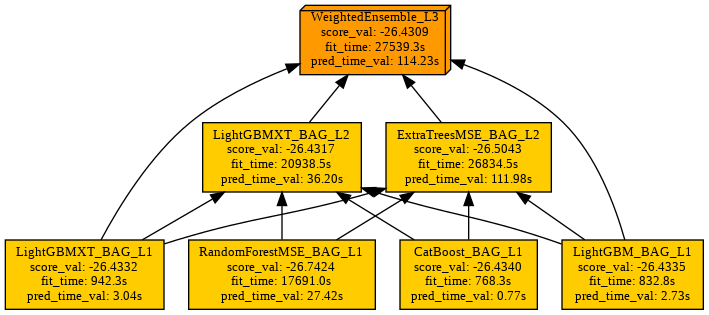

In [16]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image('./AG_beats_models/ensemble_model.png'))

In [17]:
!zip -r AG_beats_predictions{NAME_EXT}.zip /kaggle/working/AG_beats_predictions{NAME_EXT}

  adding: kaggle/working/AG_beats_predictions_LV2_CPU/ (stored 0%)
  adding: kaggle/working/AG_beats_predictions_LV2_CPU/oofL2_ag_LV2_CPU.parquet (deflated 15%)
  adding: kaggle/working/AG_beats_predictions_LV2_CPU/predL2_ag_LV2_CPU.parquet (deflated 14%)


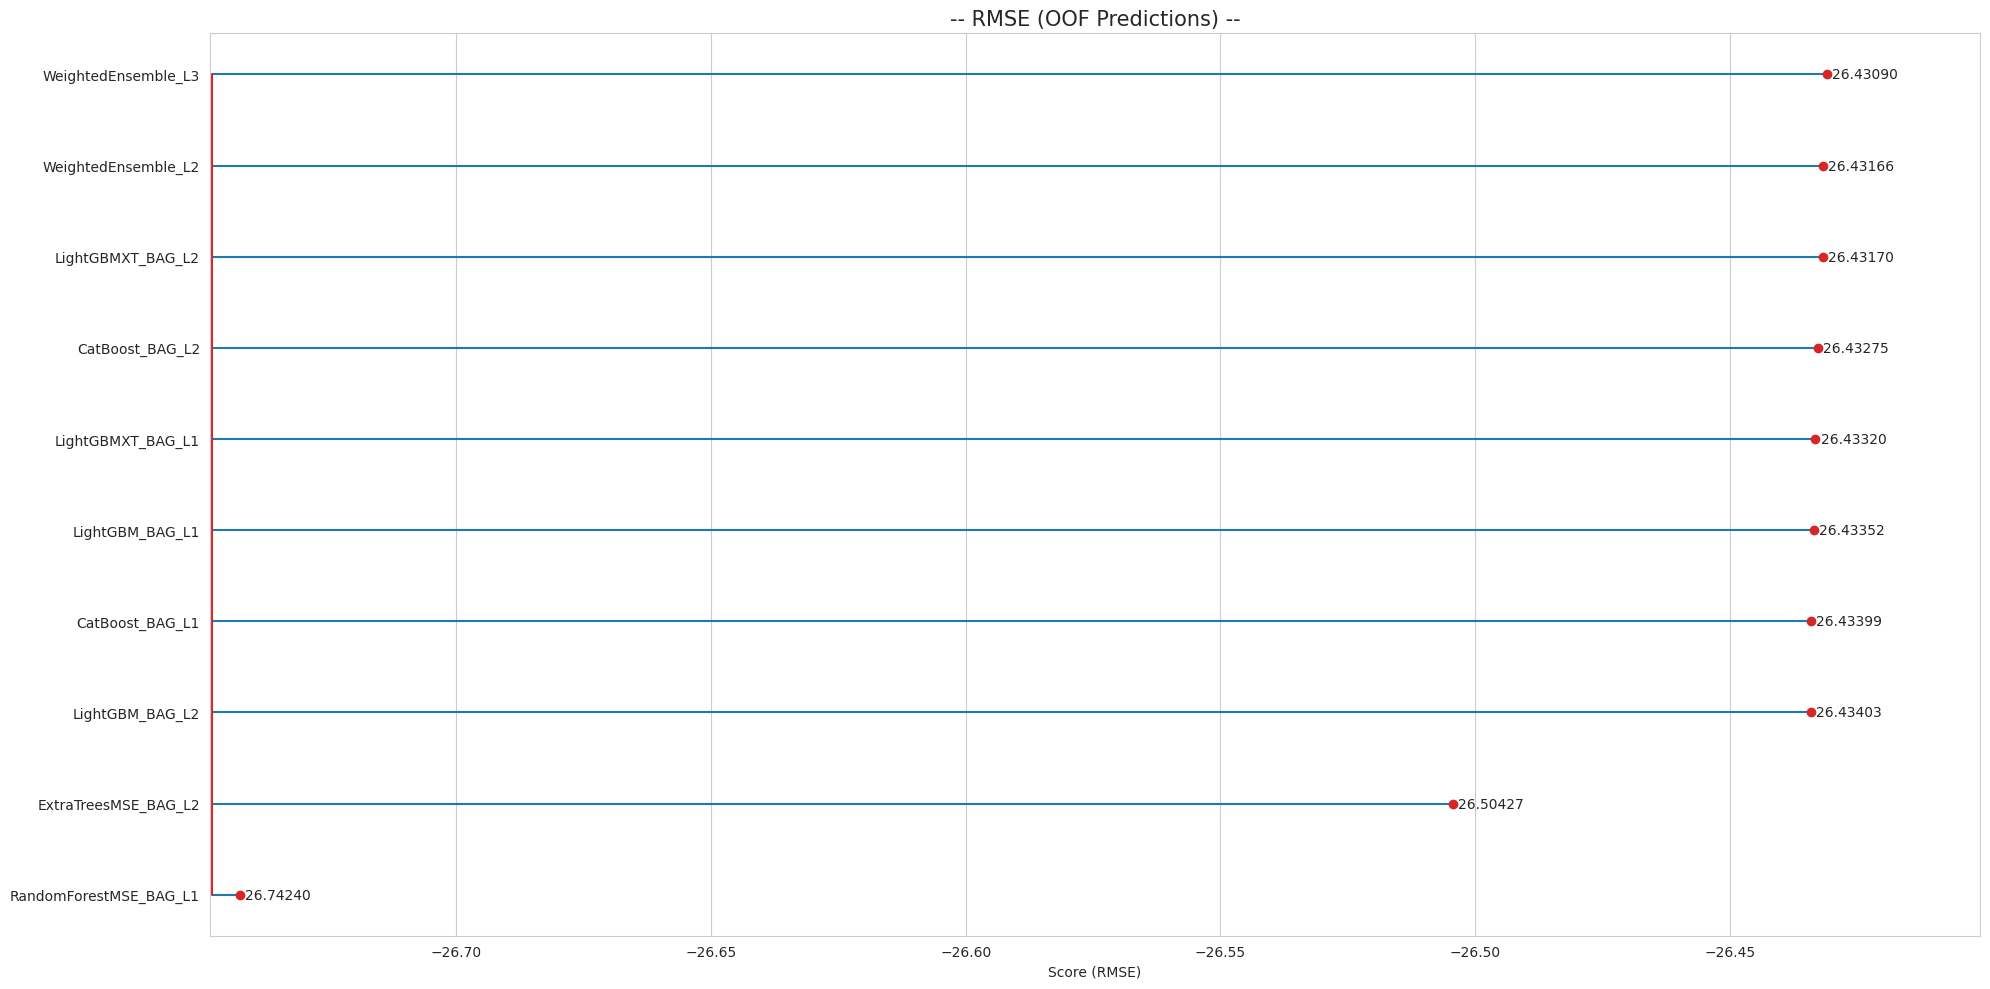

In [18]:
## -- EXTRACT MODEL AND SCORES --
result_dict = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_dict, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(20, 10))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.03)
plt.xlabel('Score (RMSE)')
plt.title('-- RMSE (OOF Predictions) --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [19]:
## -- OPTIONAL: Remove stored files --
!rm -r /kaggle/working/AG_beats_models
!rm -r /kaggle/working/AG_beats_predictions{NAME_EXT}

In [20]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

